<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Alice Graziani](https://github.com/alicegraziani25) and [Eleonora Cocciu](https://github.com/eleonoracocciu)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 21/05/2021<b>

In [24]:
# system library
import os
import sys
import json
import pickle
import isoweek
import datetime
import calendar
import operator
from tqdm.notebook import tqdm
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

# useful libraries
import math
import operator
import itertools
import statistics
import collections
from collections import Counter
from collections import OrderedDict

# pandas
import pandas as pd

# numpy
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# visualisarion
import pydotplus
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Image

# sklearn
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# dimensional reducers
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  # classification
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression  # regression

# scalers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder

# performance visualisation 
from sklearn import tree
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_decision_regions
from yellowbrick.model_selection import LearningCurve

plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

from yellowbrick.style import set_palette
set_palette('bold')

In [25]:
ts_column_name = 'frequency'

<h6> Datasets loading </h6>

In [26]:
filename = "TS_album_type_" + ts_column_name + ".csv"
df = pd.read_csv('../../data/fma_metadata/' + filename, index_col=0)
print(df.shape)

(70224, 3)


In [27]:
# retrieve Studio and Live DataFrames
studio_key = 'Studio_Recording_' + ts_column_name
live_key = 'Live_Recording_' + ts_column_name

global_studio_ts = df[studio_key].to_frame()
global_live_ts = df[live_key].to_frame()

# converting the index as date
global_studio_ts.index = pd.to_datetime(global_studio_ts.index)
global_live_ts.index = pd.to_datetime(global_live_ts.index)

# copy DataFframes
global_studio_ts_copy = global_studio_ts.copy()
global_live_ts_copy = global_live_ts.copy()

# drop 2008 and 2017
to_drop = global_studio_ts[(global_studio_ts.index.year == 2008) | (global_studio_ts.index.year == 2017)].index
global_studio_ts.drop(to_drop, axis=0, inplace=True)
to_drop = global_live_ts[(global_live_ts.index.year == 2008) | (global_live_ts.index.year == 2017)].index
global_live_ts.drop(to_drop, axis=0, inplace=True)

# channging datetime index frequency
studio_list_of_dataframes = {}
live_list_of_dataframes = {}
granularities = ['Y', 'M', 'W', 'D', 'H']

for g in granularities:
    
    # converting the index as date
    tmp_studio_ts = global_studio_ts.copy()
    studio_list_of_dataframes[g] = tmp_studio_ts.resample(g).sum()
    
    tmp_live_ts = global_live_ts.copy()
    live_list_of_dataframes[g] = tmp_live_ts.resample(g).sum()
    
for key, value in studio_list_of_dataframes.items():
    print("granularity=%s" % key, "shape=%s" % value.shape[0], sep='\t')

granularity=Y	shape=8
granularity=M	shape=96
granularity=W	shape=418
granularity=D	shape=2922
granularity=H	shape=70128


<h2>Data normalisation</h2>

In [28]:
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [29]:
# NORMALISATION
tslearn_studio_list_of_dataframes = {}
tslearn_live_list_of_dataframes = {}
for g in granularities:
    studio_ts = to_time_series_dataset(studio_list_of_dataframes[g].T.values)
    scaler = TimeSeriesScalerMeanVariance()
    studio_ts = scaler.fit_transform(studio_ts)
    tslearn_studio_list_of_dataframes[g] = studio_ts
    studio_ts = studio_ts.squeeze()
    studio_list_of_dataframes[g] = pd.DataFrame(studio_ts, index=studio_list_of_dataframes[g].index, columns=studio_list_of_dataframes[g].columns)
    
    live_ts = to_time_series_dataset(live_list_of_dataframes[g].T.values)
    scaler = TimeSeriesScalerMeanVariance()
    live_ts = scaler.fit_transform(live_ts)
    tslearn_live_list_of_dataframes[g] = live_ts
    live_ts = live_ts.squeeze()
    live_list_of_dataframes[g] = pd.DataFrame(live_ts, index=live_list_of_dataframes[g].index, columns=live_list_of_dataframes[g].columns)

<h2>Data approximation</h2>

In [30]:
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation, OneD_SymbolicAggregateApproximation

In [31]:
def my_approximation(dataset, g, name, n_paa_segments, n_sax_symbols, n_sax_symbols_avg, n_sax_symbols_slope):
    # PAA transform (and inverse transform) of the data
    paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
    paa_dataset_inv = paa.inverse_transform(paa.fit_transform(dataset))

    # SAX transform (and inverse transform) of the data
    sax = SymbolicAggregateApproximation(n_segments=n_paa_segments,
                                         alphabet_size_avg=n_sax_symbols)
    sax_dataset_inv = sax.inverse_transform(sax.fit_transform(dataset))

    # 1d-SAX transform (and inverse transform) of the data
    one_d_sax = OneD_SymbolicAggregateApproximation(
        n_segments=n_paa_segments,
        alphabet_size_avg=n_sax_symbols_avg,
        alphabet_size_slope=n_sax_symbols_slope)
    transformed_data = one_d_sax.fit_transform(dataset)
    one_d_sax_dataset_inv = one_d_sax.inverse_transform(transformed_data)


    # plot approximations
    plt.figure(figsize=(20, 15))
    plt.subplot(3, 3, 1)  #  PAA
    plt.plot(dataset[0].ravel(), "b-", alpha=0.5)
    plt.plot(paa_dataset_inv[0].ravel(), "b-")
    plt.xlabel(g)
    plt.ylabel("%s" % name)
    plt.title("PAA, %d segments" % n_paa_segments)

    plt.subplot(3, 3, 2)  # SAX
    plt.plot(dataset[0].ravel(), "b-", alpha=0.5)
    plt.plot(sax_dataset_inv[0].ravel(), "b-")
    plt.xlabel(g)
    plt.ylabel("%s" % name)
    plt.title("SAX, %d segments and %d symbols" % (n_paa_segments, n_sax_symbols))

    plt.subplot(3, 3, 3)  # 1d-SAX
    plt.plot(dataset[0].ravel(), "b-", alpha=0.4)
    plt.plot(one_d_sax_dataset_inv[0].ravel(), "b-")
    plt.xlabel(g)
    plt.ylabel("%s" % name)
    plt.title("1d-SAX, %d symbols"
              "(%dx%d)" % (n_sax_symbols_avg * n_sax_symbols_slope,
                           n_sax_symbols_avg,
                           n_sax_symbols_slope))

    plt.show()
    
    # map regions/symnols
    paa_map_symbols = {k: v for v, k in enumerate(np.unique(paa_dataset_inv.ravel()))}
    sax_map_symbols = {k: v for v, k in enumerate(np.unique(sax_dataset_inv.ravel()))}
    one_d_sax_map_symbols = {k: v for v, k in enumerate(np.unique(one_d_sax_dataset_inv.ravel()))}
    
    paa_seq = np.array([paa_map_symbols[v] for v in paa_dataset_inv.ravel()])
    sax_seq = np.array([sax_map_symbols[v] for v in sax_dataset_inv.ravel()])
    one_d_sax_seq = np.array([one_d_sax_map_symbols[v] for v in one_d_sax_dataset_inv.ravel()])
    
    return paa_map_symbols, sax_map_symbols, one_d_sax_map_symbols, paa_seq, sax_seq, one_d_sax_seq

<h1>Studio Recording Approximation </h1>

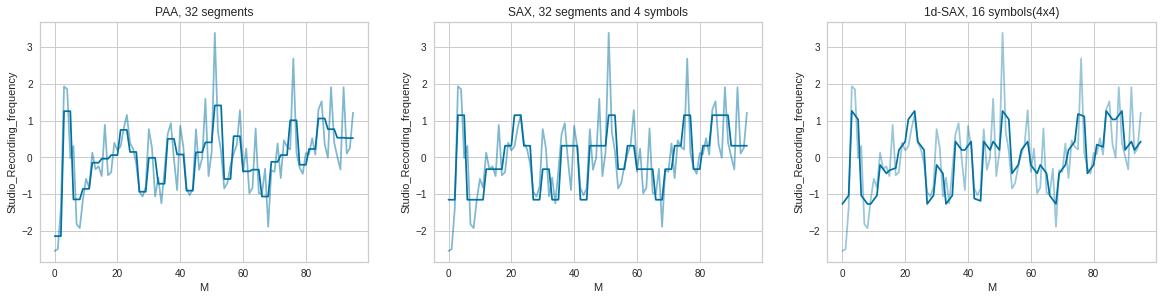

In [32]:
g = 'M'
studio_name = list(studio_list_of_dataframes[g].columns)[0]
studio_dataset = tslearn_studio_list_of_dataframes[g]
paa_map_symbols, sax_map_symbols, one_d_sax_map_symbols, paa_seq, sax_seq, one_d_sax_seq = \
                my_approximation(studio_dataset, g, studio_name, n_paa_segments=32, 
                        n_sax_symbols=4, n_sax_symbols_avg=4, n_sax_symbols_slope=4)

In [33]:
paa_map_symbols

{-2.1415073925022923: 0,
 -1.141994215909153: 1,
 -1.0635155368309566: 2,
 -0.9338077200211599: 3,
 -0.9043782153668363: 4,
 -0.8542390592890997: 5,
 -0.7158113892483923: 6,
 -0.5871935540924594: 7,
 -0.3768270948967387: 8,
 -0.33213784708832134: 9,
 -0.19916008531693316: 10,
 -0.1435710209698774: 11,
 -0.11959142458487297: 12,
 -0.03457285558349362: 13,
 -0.009503277544625396: 14,
 0.0635254932642518: 15,
 0.06461547491811565: 16,
 0.08096519972607319: 17,
 0.1409141906885843: 18,
 0.149634043919495: 19,
 0.230292686305419: 20,
 0.4112296408468161: 21,
 0.50605804473297: 22,
 0.5267676961563829: 23,
 0.5365775310411575: 24,
 0.5790868155418472: 25,
 0.7502139351984697: 26,
 0.7698336049680187: 27,
 1.011809532125791: 28,
 1.0608587065496635: 29,
 1.259235367552882: 30,
 1.4161927257092746: 31}

In [34]:
sax_map_symbols

{-1.1503493803760079: 0,
 -0.31863936396437514: 1,
 0.31863936396437514: 2,
 1.1503493803760079: 3}

In [35]:
one_d_sax_map_symbols

{-1.2653843184136087: 0,
 -1.1822133167724453: 1,
 -1.1503493803760079: 2,
 -1.1184854439795704: 3,
 -1.035314442338407: 4,
 -0.43367430200197593: 5,
 -0.3505033003608127: 6,
 -0.31863936396437514: 7,
 -0.2867754275679376: 8,
 -0.20360442592677436: 9,
 0.20360442592677436: 10,
 0.2867754275679376: 11,
 0.31863936396437514: 12,
 0.3505033003608127: 13,
 0.43367430200197593: 14,
 1.035314442338407: 15,
 1.1184854439795704: 16,
 1.1503493803760079: 17,
 1.1822133167724453: 18,
 1.2653843184136087: 19}

<h1>Studio Recording Sequential Pattern Mining</h1>

In [36]:
from prefixspan import PrefixSpan

<h2> PAA Singleton Sequential Pattern Mining </h2>

In [37]:
g_unique_values = 12
approximation_type = "PAA"
map_symbols = paa_map_symbols
seq = paa_seq

In [38]:
def plot_db(db, name):
    years = list(range(2009, 2017))
    colors = ["blue", "lime", "orange", "yellow", "red", "black", "cyan", "fuchsia"]

    fig = plt.subplots(figsize=(15, 3))
    fig_dims = (1, 8)
    for i in range(0, len(db)):
        ax = plt.subplot2grid(fig_dims, (0, i))
        plt.plot(db[i], color=colors[i])
        ax.set_xlabel(g)
        if i == 0:
            ax.set_ylabel("%s symbols" % approximation_type)
        ax.set_title(years[i])
    plt.suptitle("%s data sequences dataset" % name.replace("_frequency", ""), fontsize="x-large", y=1.05)
    plt.tight_layout()
    plt.show()

In [39]:
def get_min_supp():
    global_matches = {}
    for min_supp in range(1, len(db)+1):
        matches = ps.frequent(min_supp, closed=True)
        if len(matches) == 0:
            print("NO SP present with min_supp=%s" % min_supp)
            global_matches[min_supp] = {}
            for elemen_len in range(1, g_unique_values+1):
                 global_matches[min_supp][elemen_len] = 0
            continue

        # collect frequency statistics
        elemen_len_dict = {}
        for elemen_len in range(1, g_unique_values+1):
            elemen_len_dict[elemen_len] = 0

        for supp, patt in matches:
            elemen_len = len(patt)
            elemen_len_dict[elemen_len] += 1

        global_matches[min_supp] = {}
        for key, value in elemen_len_dict.items():
            global_matches[min_supp][key] = value
            if value > 0:
                print("min_supp=%s" % min_supp, "elemen_len=%s" % key, "freqeuncy=%s" % value, sep="\t")
        print()
        
    return global_matches

In [40]:
def plot_min_supp(global_matches, name):
    fig = plt.subplots(figsize=(15, 3))
    fig_dims = (1, 8)
    for i in range(1, len(global_matches)+1):
        ax = plt.subplot2grid(fig_dims, (0, i-1))
        plt.plot(list(global_matches[i].keys()), list(global_matches[i].values()))
        ax.set_xlabel("min_lenght")
        if i == 1:
            ax.set_ylabel("# of frequent patterns")
        ax.set_title("min_supp=%s" % i)
    plt.suptitle("%s sequential patterns" % name.replace("_frequency", ""), fontsize="x-large", y=1.05)
    plt.tight_layout()
    plt.show()

In [41]:
# creating a database made out of N data sequences, with N=8 years
# each data sequence has 12 elements, each one made out of an event
def get_db():
    db = []
    data_seq = []
    change_points = list(range(g_unique_values, len(seq), g_unique_values))
    for i in range(0, len(seq)):
        if i in change_points:
            db.append(data_seq)
            data_seq = []
        data_seq.append(seq[i])
    db.append(data_seq)  # append last data sequence
    return db

In [42]:
db = get_db() 
db

[[0, 0, 0, 30, 30, 30, 1, 1, 1, 5, 5, 5],
 [11, 11, 11, 13, 13, 13, 15, 15, 15, 26, 26, 26],
 [19, 19, 19, 3, 3, 3, 14, 14, 14, 6, 6, 6],
 [22, 22, 22, 17, 17, 17, 4, 4, 4, 18, 18, 18],
 [21, 21, 21, 31, 31, 31, 7, 7, 7, 25, 25, 25],
 [8, 8, 8, 9, 9, 9, 2, 2, 2, 12, 12, 12],
 [16, 16, 16, 28, 28, 28, 10, 10, 10, 20, 20, 20],
 [29, 29, 29, 27, 27, 27, 24, 24, 24, 23, 23, 23]]

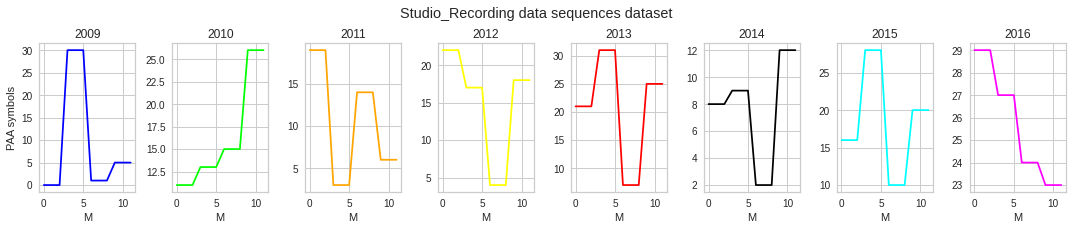

In [43]:
plot_db(db, studio_name)

<h6>Retrieve top sequential patterns</h6>

In [44]:
# searchin frequent sequential patterns
ps = PrefixSpan(db)

In [45]:
# looking for top-k, closed sequential patterns
ps.topk(10, closed=True)

[(1, [0, 0, 0, 30, 30, 30, 1, 1, 1, 5, 5, 5]),
 (1, [8, 8, 8, 9, 9, 9, 2, 2, 2, 12, 12, 12]),
 (1, [11, 11, 11, 13, 13, 13, 15, 15, 15, 26, 26, 26]),
 (1, [16, 16, 16, 28, 28, 28, 10, 10, 10, 20, 20, 20]),
 (1, [19, 19, 19, 3, 3, 3, 14, 14, 14, 6, 6, 6]),
 (1, [21, 21, 21, 31, 31, 31, 7, 7, 7, 25, 25, 25]),
 (1, [22, 22, 22, 17, 17, 17, 4, 4, 4, 18, 18, 18]),
 (1, [29, 29, 29, 27, 27, 27, 24, 24, 24, 23, 23, 23])]

<h6>Analyzed how different min_supp and min_lenght changes sequential patterns' discovery </h6>

In [46]:
# print statistics for all min_supp threshold and element's length
global_matches = get_min_supp()

min_supp=1	elemen_len=12	freqeuncy=8

NO SP present with min_supp=2
NO SP present with min_supp=3
NO SP present with min_supp=4
NO SP present with min_supp=5
NO SP present with min_supp=6
NO SP present with min_supp=7
NO SP present with min_supp=8


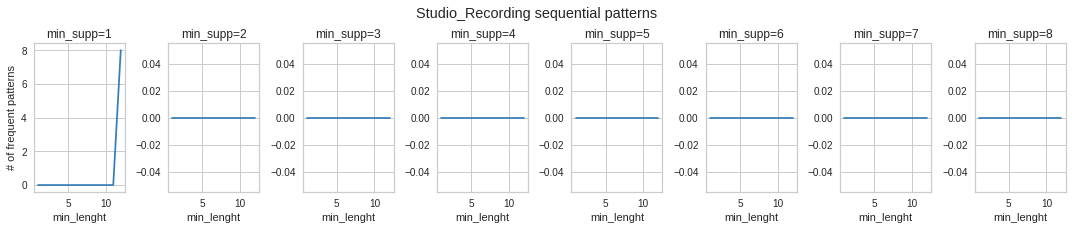

In [47]:
# plot statistics for all min_supp threshold and element's length 
plot_min_supp(global_matches, studio_name)

<h2> SAX Singleton Sequential Pattern Mining </h2>

In [48]:
g_unique_values = 12
approximation_type = "SAX"
map_symbols = sax_map_symbols
seq = sax_seq

<h6> Create data sequences database </h6>

In [49]:
db = get_db() 
db

[[0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3],
 [2, 2, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0],
 [2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2],
 [2, 2, 2, 3, 3, 3, 1, 1, 1, 2, 2, 2],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
 [2, 2, 2, 3, 3, 3, 1, 1, 1, 2, 2, 2],
 [3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2]]

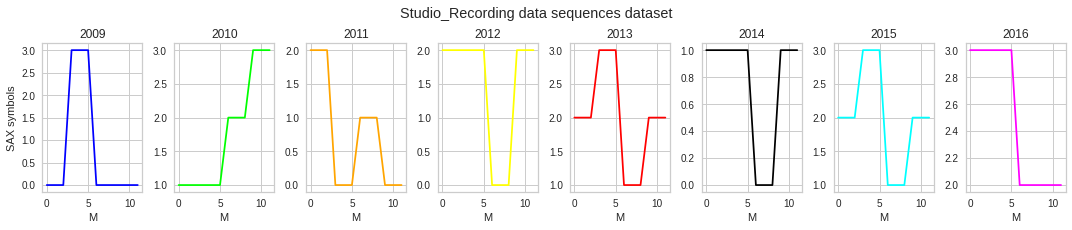

In [50]:
plot_db(db, studio_name)

<h6>Retrieve top sequential patterns</h6>

In [51]:
# searchin frequent sequential patterns
ps = PrefixSpan(db)

In [52]:
# looking for top-k, closed sequential patterns
ps.topk(10, closed=True)

[(6, [2, 2, 2]),
 (5, [1, 1, 1]),
 (5, [3, 3, 3]),
 (4, [0, 0, 0]),
 (4, [2, 2, 2, 2, 2, 2]),
 (3, [1, 1, 1, 2, 2, 2]),
 (3, [2, 2, 2, 1, 1, 1]),
 (3, [2, 2, 2, 3, 3, 3]),
 (3, [3, 3, 3, 2, 2, 2]),
 (2, [2, 2, 2, 3, 3, 3, 1, 1, 1, 2, 2, 2])]

<h6>Analyzed how different min_supp and min_lenght changes sequential patterns' discovery </h6>

In [53]:
# print statistics for all min_supp threshold and element's length
global_matches = get_min_supp()

min_supp=1	elemen_len=3	freqeuncy=4
min_supp=1	elemen_len=6	freqeuncy=10
min_supp=1	elemen_len=12	freqeuncy=7

min_supp=2	elemen_len=3	freqeuncy=4
min_supp=2	elemen_len=6	freqeuncy=10
min_supp=2	elemen_len=12	freqeuncy=1

min_supp=3	elemen_len=3	freqeuncy=4
min_supp=3	elemen_len=6	freqeuncy=5

min_supp=4	elemen_len=3	freqeuncy=4
min_supp=4	elemen_len=6	freqeuncy=1

min_supp=5	elemen_len=3	freqeuncy=3

min_supp=6	elemen_len=3	freqeuncy=1

NO SP present with min_supp=7
NO SP present with min_supp=8


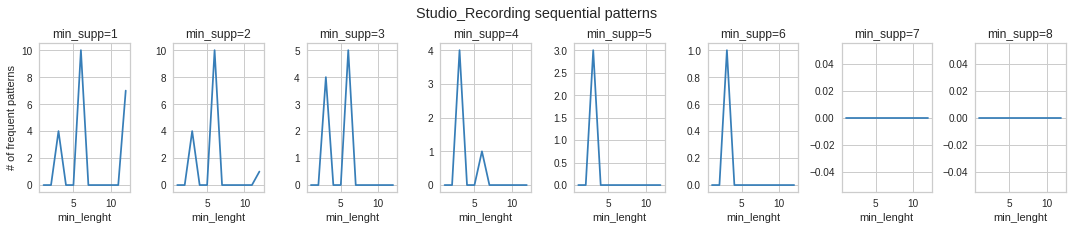

In [54]:
# plot statistics for all min_supp threshold and element's length 
plot_min_supp(global_matches, studio_name)

As expected with min_supp threshold's increasing, sequential patterns' length (number of elements) decreases \footnote{We didn't get an insight in the number of events of each element, since each event is a singleton.}. 
In particular, regarding Studio Recordings an interesting length motif arises, since only 3, 6 and 12 adjacent (min_gap=1) elements are discovered among all supports. By using a min_sup >= 4\footnote{Half of transactions present in the data sequence database.}, we can notice notice the following sequential patterns:

- [2, 2, 2] (support=6): it captures the renewal of Studio tracks at the end (2012, 2013, 2015, 2016) and begining (2010, 2011, 2012, 2015) of most years;
- [1, 1, 1] (support=5): it captures a moderate activity in 2010's and 2014's beginning and 2011's, 2013's and 2013's July-August-September trimester;
- [3, 3, 3]) (support=5):  it captures Studio's March-April-May peaks (2009, 2013, 2015, 2016) and an increasing activity approaching 2010's Christamas;
- [0, 0, 0]) (support=4): it  it captures a moderate activity in 2009's beginning, 2011's March-April-May peaks and 2012's and 2014's July-August-September trimester.

<h2> ONE-D-SAX Singleton Sequential Pattern Mining </h2>

In [55]:
g_unique_values = 12
approximation_type = "ONE-D-SAX"
map_symbols = one_d_sax_map_symbols
seq = one_d_sax_seq

<h6> Create data sequences database </h6>

In [56]:
db = get_db() 
db

[[0, 2, 4, 19, 17, 15, 4, 2, 0, 0, 2, 4],
 [9, 7, 5, 6, 7, 8, 10, 12, 14, 15, 17, 19],
 [14, 12, 10, 0, 2, 4, 9, 7, 5, 0, 2, 4],
 [14, 12, 10, 10, 12, 14, 3, 2, 1, 14, 12, 10],
 [14, 12, 10, 19, 17, 15, 5, 7, 9, 10, 12, 14],
 [9, 7, 5, 9, 7, 5, 4, 2, 0, 5, 7, 9],
 [10, 12, 14, 18, 17, 16, 5, 7, 9, 13, 12, 11],
 [19, 17, 15, 15, 17, 19, 10, 12, 14, 10, 12, 14]]

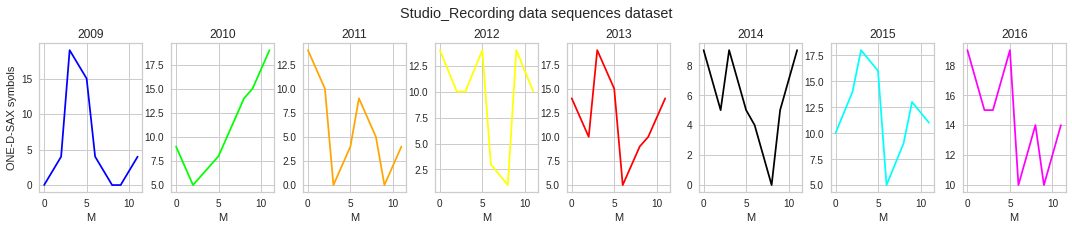

In [57]:
plot_db(db, studio_name)

<h6>Retrieve top sequential patterns</h6>

In [58]:
# searchin frequent sequential patterns
ps = PrefixSpan(db)

In [59]:
# looking for top-k, closed sequential patterns
ps.topk(10, closed=True)

[(6, [10]),
 (6, [12]),
 (6, [14]),
 (5, [5]),
 (5, [7]),
 (5, [9]),
 (5, [10, 12]),
 (5, [10, 12, 14]),
 (5, [14, 12]),
 (5, [17])]

<h6>Analyzed how different min_supp and min_lenght changes sequential patterns' discovery </h6>

In [60]:
# print statistics for all min_supp threshold and element's length
global_matches = get_min_supp()

min_supp=1	elemen_len=1	freqeuncy=11
min_supp=1	elemen_len=2	freqeuncy=42
min_supp=1	elemen_len=3	freqeuncy=13
min_supp=1	elemen_len=4	freqeuncy=18
min_supp=1	elemen_len=5	freqeuncy=4
min_supp=1	elemen_len=6	freqeuncy=6
min_supp=1	elemen_len=12	freqeuncy=8

min_supp=2	elemen_len=1	freqeuncy=11
min_supp=2	elemen_len=2	freqeuncy=42
min_supp=2	elemen_len=3	freqeuncy=13
min_supp=2	elemen_len=4	freqeuncy=18
min_supp=2	elemen_len=5	freqeuncy=4
min_supp=2	elemen_len=6	freqeuncy=6

min_supp=3	elemen_len=1	freqeuncy=11
min_supp=3	elemen_len=2	freqeuncy=26
min_supp=3	elemen_len=3	freqeuncy=9
min_supp=3	elemen_len=4	freqeuncy=4

min_supp=4	elemen_len=1	freqeuncy=10
min_supp=4	elemen_len=2	freqeuncy=6
min_supp=4	elemen_len=3	freqeuncy=1

min_supp=5	elemen_len=1	freqeuncy=7
min_supp=5	elemen_len=2	freqeuncy=2
min_supp=5	elemen_len=3	freqeuncy=1

min_supp=6	elemen_len=1	freqeuncy=3

NO SP present with min_supp=7
NO SP present with min_supp=8


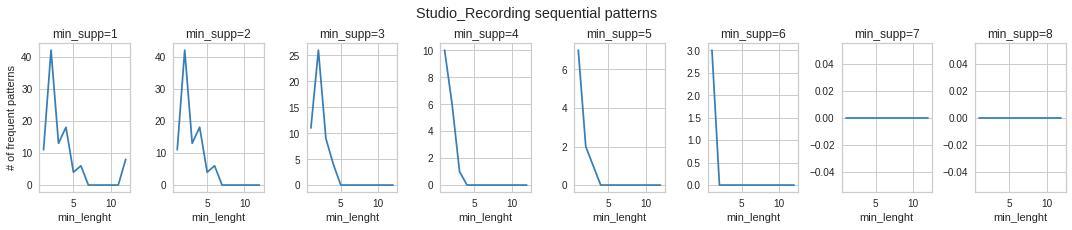

In [61]:
# plot statistics for all min_supp threshold and element's length 
plot_min_supp(global_matches, studio_name)

<h1>Live Recording Approximation </h1>

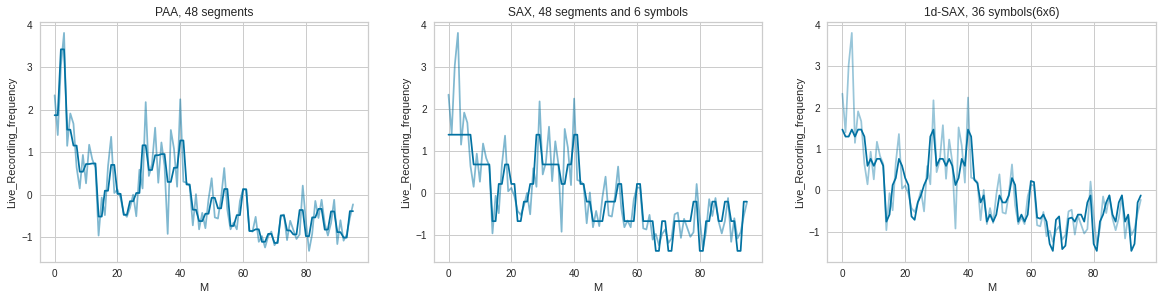

In [62]:
g = 'M'
live_name = list(live_list_of_dataframes[g].columns)[0]
live_dataset = tslearn_live_list_of_dataframes[g]
paa_map_symbols, sax_map_symbols, one_d_sax_map_symbols, paa_seq, sax_seq, one_d_sax_seq = \
                my_approximation(live_dataset, g, live_name, n_paa_segments=48, 
                        n_sax_symbols=6, n_sax_symbols_avg=6, n_sax_symbols_slope=6)

In [63]:
paa_map_symbols

{-1.140541913933617: 0,
 -1.1138006698897467: 1,
 -1.0135210047252328: 2,
 -0.9800944496703948: 3,
 -0.9399825836045893: 4,
 -0.926611961582654: 5,
 -0.8865000955168485: 6,
 -0.8597588514729781: 7,
 -0.846388229451043: 8,
 -0.8263322964181402: 9,
 -0.8196469854071726: 10,
 -0.7394232532755615: 11,
 -0.6257729660891124: 12,
 -0.5388639229465336: 13,
 -0.5188079899136309: 14,
 -0.4920667458697605: 15,
 -0.4853814348587929: 16,
 -0.47869612384782534: 17,
 -0.45195487980395493: 18,
 -0.3984723917162142: 19,
 -0.3917870807052466: 20,
 -0.36504583666137624: 21,
 -0.35836052565040866: 22,
 -0.33830459261750584: 23,
 -0.3249339705955707: 24,
 -0.15780119532138084: 25,
 -0.07757746318976971: 26,
 0.016016890963776585: 27,
 0.03607282399667938: 28,
 0.08955531208442014: 29,
 0.12298186713925809: 30,
 0.12966717815022566: 31,
 0.23663215432570717: 32,
 0.29679995342441556: 33,
 0.5374711498192489: 34,
 0.5775830158850545: 35,
 0.6310655039727951: 36,
 0.6979186140824711: 37,
 0.7179745471153738: 

In [64]:
sax_map_symbols

{-1.382994127100638: 0,
 -0.6744897501960817: 1,
 -0.2104283942479247: 2,
 0.21042839424792484: 3,
 0.6744897501960817: 4,
 1.382994127100638: 5}

In [65]:
one_d_sax_map_symbols

{-1.4676848753171978: 0,
 -1.4242980202185804: 1,
 -1.3416902339826957: 2,
 -1.2983033788840783: 3,
 -0.7591804984126413: 4,
 -0.715793643314024: 5,
 -0.6873758050285974: 6,
 -0.661603695363566: 7,
 -0.6331858570781395: 8,
 -0.5897990019795221: 9,
 -0.2951191424644844: 10,
 -0.125737646031365: 11,
 0.12573764603136514: 12,
 0.1691245011299826: 13,
 0.1975423394154092: 14,
 0.22331444908044049: 15,
 0.2517322873658671: 16,
 0.29511914246448456: 17,
 0.5897990019795221: 18,
 0.7591804984126413: 19,
 1.2983033788840783: 20,
 1.4676848753171978: 21}

<h1>Live Recording Sequential Pattern Mining Discovery </h1>

<h2> PAA Singleton Sequential Pattern Mining </h2>

In [66]:
g_unique_values = 12
approximation_type = "PAA"
map_symbols = paa_map_symbols
seq = paa_seq

In [67]:
db = get_db() 
db

[[46, 46, 47, 47, 45, 45, 42, 42, 34, 34, 38, 38],
 [39, 39, 14, 14, 29, 29, 37, 37, 27, 27, 17, 17],
 [25, 25, 28, 28, 43, 43, 35, 35, 40, 40, 41, 41],
 [33, 33, 36, 36, 44, 44, 32, 32, 22, 22, 12, 12],
 [18, 18, 26, 26, 24, 24, 31, 31, 11, 11, 16, 16],
 [30, 30, 7, 7, 10, 10, 1, 1, 5, 5, 0, 0],
 [15, 15, 8, 8, 4, 4, 21, 21, 3, 3, 13, 13],
 [23, 23, 9, 9, 19, 19, 6, 6, 2, 2, 20, 20]]

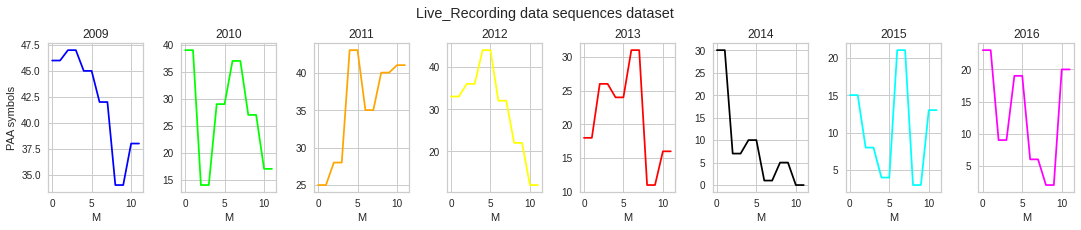

In [68]:
plot_db(db, live_name)

<h6>Retrieve top sequential patterns</h6>

In [69]:
# searchin frequent sequential patterns
ps = PrefixSpan(db)

In [70]:
# looking for top-k, closed sequential patterns
ps.topk(10, closed=True)

[(1, [15, 15, 8, 8, 4, 4, 21, 21, 3, 3, 13, 13]),
 (1, [18, 18, 26, 26, 24, 24, 31, 31, 11, 11, 16, 16]),
 (1, [23, 23, 9, 9, 19, 19, 6, 6, 2, 2, 20, 20]),
 (1, [25, 25, 28, 28, 43, 43, 35, 35, 40, 40, 41, 41]),
 (1, [30, 30, 7, 7, 10, 10, 1, 1, 5, 5, 0, 0]),
 (1, [33, 33, 36, 36, 44, 44, 32, 32, 22, 22, 12, 12]),
 (1, [39, 39, 14, 14, 29, 29, 37, 37, 27, 27, 17, 17]),
 (1, [46, 46, 47, 47, 45, 45, 42, 42, 34, 34, 38, 38])]

<h6>Analyzed how different min_supp and min_lenght changes sequential patterns' discovery </h6>

In [71]:
# print statistics for all min_supp threshold and element's length
global_matches = get_min_supp()

min_supp=1	elemen_len=12	freqeuncy=8

NO SP present with min_supp=2
NO SP present with min_supp=3
NO SP present with min_supp=4
NO SP present with min_supp=5
NO SP present with min_supp=6
NO SP present with min_supp=7
NO SP present with min_supp=8


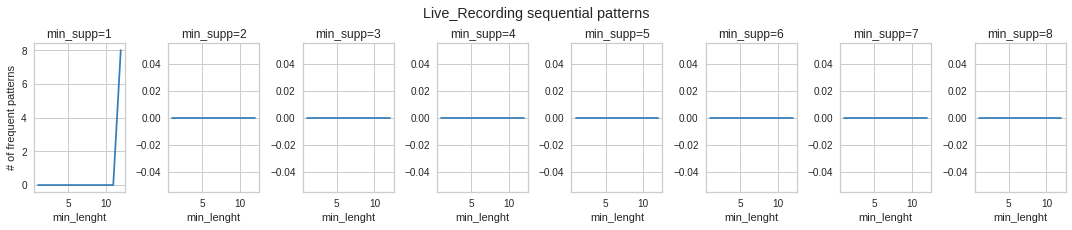

In [72]:
# plot statistics for all min_supp threshold and element's length 
plot_min_supp(global_matches, live_name)

<h2> SAX Singleton Sequential Pattern Mining </h2>

In [73]:
g_unique_values = 12
approximation_type = "SAX"
map_symbols = sax_map_symbols
seq = sax_seq

<h6> Create data sequences database </h6>

In [74]:
db = get_db() 
db

[[5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4],
 [4, 4, 1, 1, 3, 3, 4, 4, 3, 3, 1, 1],
 [2, 2, 3, 3, 5, 5, 4, 4, 4, 4, 4, 4],
 [3, 3, 4, 4, 5, 5, 3, 3, 2, 2, 1, 1],
 [1, 1, 2, 2, 2, 2, 3, 3, 1, 1, 1, 1],
 [3, 3, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 1, 1],
 [2, 2, 1, 1, 2, 2, 1, 1, 0, 0, 2, 2]]

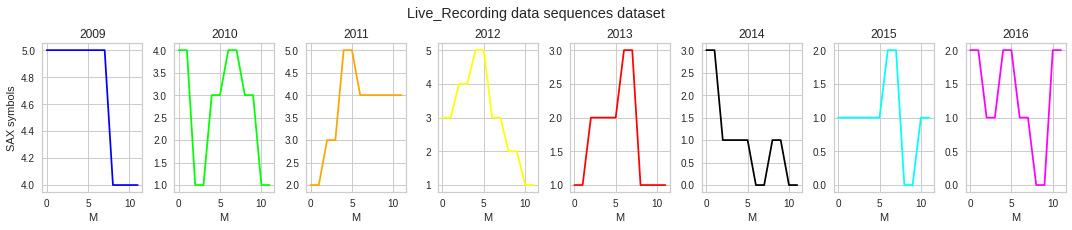

In [75]:
plot_db(db, live_name)

Mostly, for every tested min_supp, Live sequential patterns are made out of 2, 4, 6, 8 or 12 adjacent elements. Firstly, we can clearly notice how 2009 is approximated more as a stationary year. In fact, it is less dynamic than the other years. By using a min_sup >= 4, we can notice the following sequential patterns:

- [1, 1] (support=7): it captures 2010's, 2014's, 2015's and 2016's March-April moderate activity approaching Easter and 2010's, 2012's, 2013's and 2014's  moderate activity approaching Christmas.

<h6>Retrieve top sequential patterns</h6>

In [76]:
# searchin frequent sequential patterns
ps = PrefixSpan(db)

In [77]:
# looking for top-k, closed sequential patterns
ps.topk(10, closed=True)

[(6, [1, 1]),
 (5, [1, 1, 1, 1]),
 (5, [2, 2]),
 (5, [3, 3]),
 (4, [2, 2, 1, 1]),
 (4, [3, 3, 1, 1]),
 (4, [4, 4]),
 (3, [1, 1, 2, 2]),
 (3, [1, 1, 2, 2, 1, 1]),
 (3, [3, 3, 4, 4])]

<h6>Analyzed how different min_supp and min_lenght changes sequential patterns' discovery </h6>

In [78]:
# print statistics for all min_supp threshold and element's length
global_matches = get_min_supp()

min_supp=1	elemen_len=2	freqeuncy=5
min_supp=1	elemen_len=4	freqeuncy=8
min_supp=1	elemen_len=6	freqeuncy=11
min_supp=1	elemen_len=8	freqeuncy=3
min_supp=1	elemen_len=12	freqeuncy=8

min_supp=2	elemen_len=2	freqeuncy=5
min_supp=2	elemen_len=4	freqeuncy=8
min_supp=2	elemen_len=6	freqeuncy=11
min_supp=2	elemen_len=8	freqeuncy=3

min_supp=3	elemen_len=2	freqeuncy=5
min_supp=3	elemen_len=4	freqeuncy=6
min_supp=3	elemen_len=6	freqeuncy=3

min_supp=4	elemen_len=2	freqeuncy=4
min_supp=4	elemen_len=4	freqeuncy=3

min_supp=5	elemen_len=2	freqeuncy=3
min_supp=5	elemen_len=4	freqeuncy=1

min_supp=6	elemen_len=2	freqeuncy=1

NO SP present with min_supp=7
NO SP present with min_supp=8


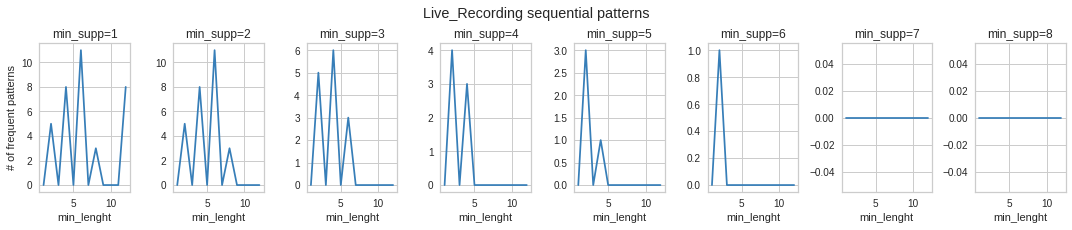

In [79]:
# plot statistics for all min_supp threshold and element's length 
plot_min_supp(global_matches, live_name)

<h2> ONE-D-SAX Singleton Sequential Pattern Mining </h2>

In [80]:
g_unique_values = 12
approximation_type = "ONE-D-SAX"
map_symbols = one_d_sax_map_symbols
seq = one_d_sax_seq

<h6> Create data sequences database </h6>

In [81]:
db = get_db() 
db

[[21, 20, 20, 21, 20, 21, 21, 20, 18, 19, 18, 19],
 [19, 18, 4, 9, 12, 17, 19, 18, 17, 12, 8, 5],
 [10, 11, 12, 17, 20, 21, 18, 19, 19, 18, 19, 18],
 [12, 17, 19, 18, 21, 20, 16, 13, 10, 11, 4, 9],
 [4, 9, 11, 10, 10, 11, 17, 12, 4, 9, 4, 9],
 [15, 14, 7, 6, 9, 4, 3, 0, 5, 8, 1, 2],
 [6, 7, 4, 9, 9, 4, 10, 11, 3, 0, 4, 9],
 [10, 11, 9, 4, 10, 11, 4, 9, 0, 3, 10, 11]]

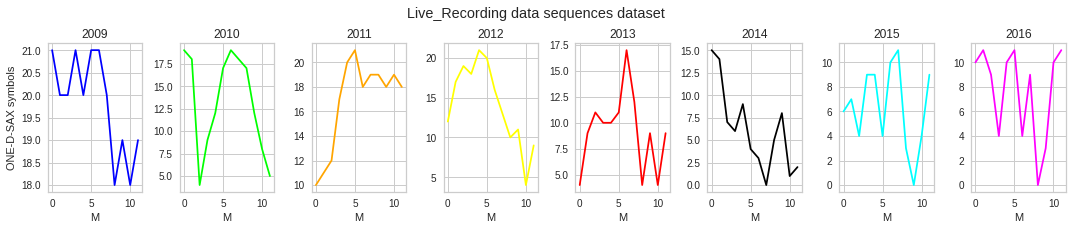

In [82]:
plot_db(db, live_name)

<h6>Retrieve top sequential patterns</h6>

In [83]:
# searchin frequent sequential patterns
ps = PrefixSpan(db)

In [84]:
# looking for top-k, closed sequential patterns
ps.topk(10, closed=True)

[(6, [4]),
 (6, [9]),
 (5, [4, 9]),
 (5, [10, 11]),
 (4, [9, 4]),
 (4, [10, 11, 4, 9]),
 (4, [12]),
 (4, [17]),
 (4, [19]),
 (4, [19, 18])]

<h6>Analyzed how different min_supp and min_lenght changes sequential patterns' discovery </h6>

In [85]:
# print statistics for all min_supp threshold and element's length
global_matches = get_min_supp()

min_supp=1	elemen_len=1	freqeuncy=7
min_supp=1	elemen_len=2	freqeuncy=14
min_supp=1	elemen_len=3	freqeuncy=19
min_supp=1	elemen_len=4	freqeuncy=16
min_supp=1	elemen_len=5	freqeuncy=14
min_supp=1	elemen_len=6	freqeuncy=3
min_supp=1	elemen_len=12	freqeuncy=8

min_supp=2	elemen_len=1	freqeuncy=7
min_supp=2	elemen_len=2	freqeuncy=14
min_supp=2	elemen_len=3	freqeuncy=19
min_supp=2	elemen_len=4	freqeuncy=16
min_supp=2	elemen_len=5	freqeuncy=14
min_supp=2	elemen_len=6	freqeuncy=3

min_supp=3	elemen_len=1	freqeuncy=7
min_supp=3	elemen_len=2	freqeuncy=7
min_supp=3	elemen_len=3	freqeuncy=5
min_supp=3	elemen_len=4	freqeuncy=4
min_supp=3	elemen_len=5	freqeuncy=2

min_supp=4	elemen_len=1	freqeuncy=5
min_supp=4	elemen_len=2	freqeuncy=4
min_supp=4	elemen_len=4	freqeuncy=1

min_supp=5	elemen_len=1	freqeuncy=2
min_supp=5	elemen_len=2	freqeuncy=2

min_supp=6	elemen_len=1	freqeuncy=2

NO SP present with min_supp=7
NO SP present with min_supp=8


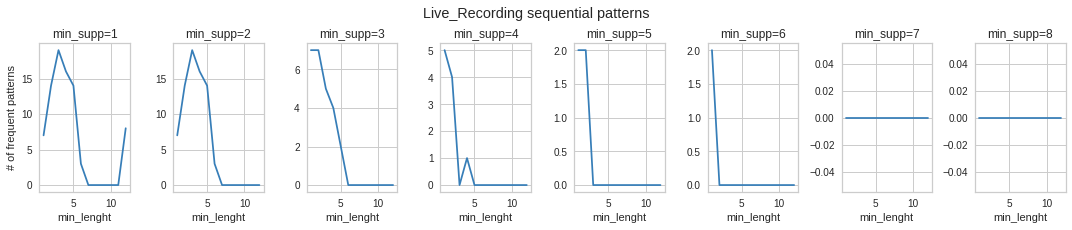

In [86]:
# plot statistics for all min_supp threshold and element's length 
plot_min_supp(global_matches, live_name)